In [7]:
import matplotlib.pyplot as plt
import corner

In [6]:
import pandas as pd

# Path to the specific file
file_path = "/home/localuser/Documents/DataAnalysis/lec5/Kepler/spec_006852836.txt"
# file_path = '/home/localuser/Documents/DataAnalysis/lec5/Kepler/spec_003645232.txt'

# Function to parse the specified Kepler data file
def parse_kepler_file(filepath):
    metadata = {}
    data = []
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
        # Extract metadata from header
        for line in lines:
            if line.startswith("#"):
                if "mission" in line or "ID" in line or "numax" in line or "Dnu" in line:
                    key, value = line.strip("#").strip().split(maxsplit=1)
                    metadata[key.strip()] = value.strip()
            else:
                # Extract numerical data
                try:
                    freq, power = map(float, line.split())
                    data.append((freq, power))
                except ValueError:
                    continue
    
    # Convert data to DataFrame
    data_df = pd.DataFrame(data, columns=["Frequency (microHz)", "Power Density (ppm^2/microHz)"])
    return metadata, data_df

# Parse the specified file
metadata, data_df = parse_kepler_file(file_path)

# Display metadata and data
metadata, data_df.head()


({'mission': 'Kepler', 'ID': '006852836', 'numax': '31.44', 'Dnu': '4.005'},
    Frequency (microHz)  Power Density (ppm^2/microHz)
 0             0.008052                      1799.6007
 1             0.016104                     36227.4300
 2             0.024156                      2097.5575
 3             0.032208                     10862.6990
 4             0.040260                      2126.6521)

/tmp/ipykernel_5344/1624685044.py:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 100)


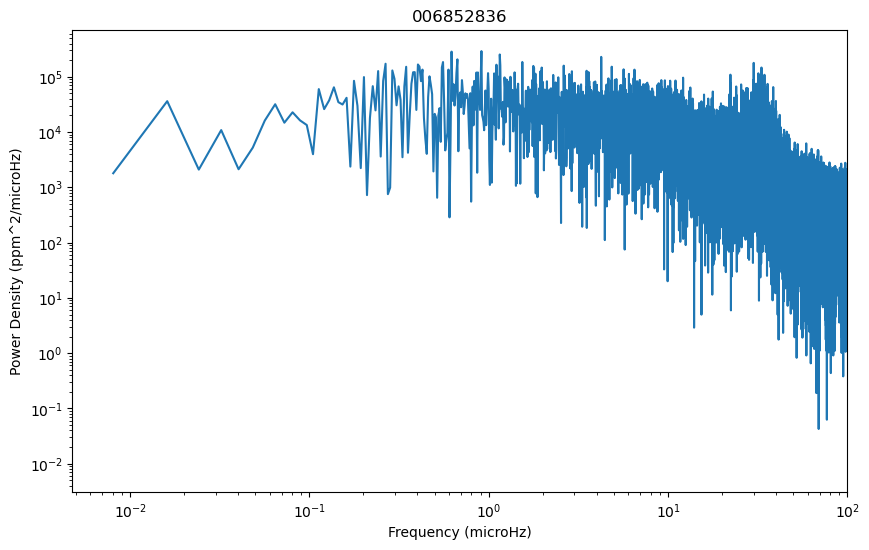

In [8]:
# data_df
plt.figure(figsize=(10, 6))
# 
plt.loglog(data_df["Frequency (microHz)"], data_df["Power Density (ppm^2/microHz)"])
plt.xlabel("Frequency (microHz)")
plt.ylabel("Power Density (ppm^2/microHz)")
# plt.yscale("log")
plt.xlim(0, 100)
plt.title(metadata["ID"])
# plt.yscale("log")
plt.show()



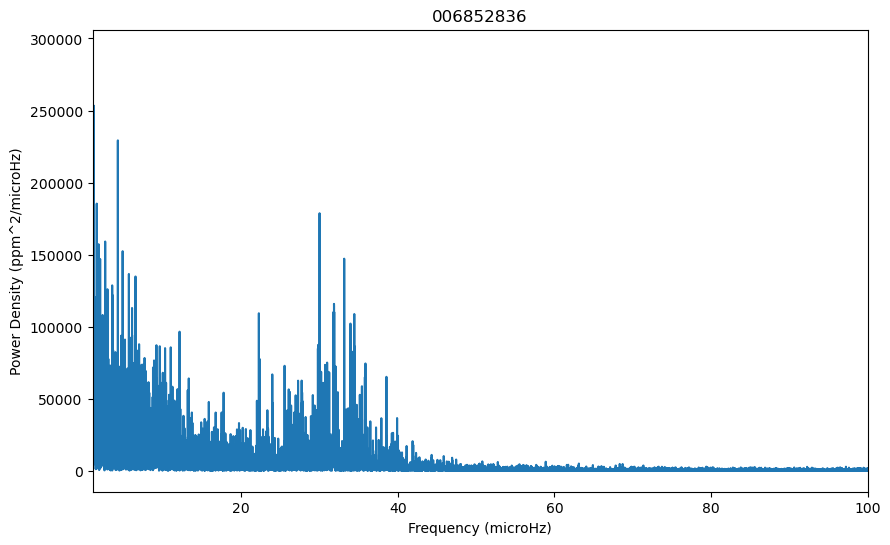

In [10]:
# plot the psd in 1-100 microHz
plt.figure(figsize=(10, 6))

plt.plot(data_df["Frequency (microHz)"], data_df["Power Density (ppm^2/microHz)"])
plt.xlabel("Frequency (microHz)")
plt.ylabel("Power Density (ppm^2/microHz)")
plt.xlim(1, 100)
plt.title(metadata["ID"])
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
def noisModel(nu, B_nu_max, beta, A, nu_max, sigma, P_photon):
    background = B_nu_max * (nu / nu_max)**beta
    # gaussian = A * np.exp(-0.5 * ((nu - nu_max) / sigma)**2)
    return background  + P_photon
# Define the power spectrum model
def power_spectrum_model(nu, B_nu_max, beta, A, nu_max, sigma, P_photon):
    background = B_nu_max * (nu / nu_max)**beta
    gaussian = A * np.exp(-0.5 * ((nu - nu_max) / sigma)**2)
    return background + gaussian + P_photon

# Log-likelihood function
def log_likelihood(params, nu, power_density):
    B_nu_max, beta, A, nu_max, sigma, P_photon = params
    model = power_spectrum_model(nu, B_nu_max, beta, A, nu_max, sigma, P_photon)
    return - np.sum(np.log(model)+ power_density/model)

def log_prior(params):
    B_nu_max, beta, A, nu_max, sigma, P_photon = params
    if 0 < B_nu_max < 1e6 and -2< beta < -1 and 0 < A < 1e6 and 1 < nu_max < 40 and 0 < sigma < 10 and 0 < P_photon < 1e3:
        return 0.0
    return -np.inf

# Combined log-probability function
def log_probability(params, nu, power_density):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, nu, power_density)



In [11]:
##############################################################
# 
# mission     Kepler
# ID       006852836
# numax      31.44
# Dnu        4.005
# epsilon    0.933
# alpha     0.0110
# background  2616.79  -1.94
# magV        0.00
# Teff        5106
# logg        3.30
# Z          -0.04
b_nu_max = 2616.79
beta = -1.94
A = 1e4
nu_max = 39.23
sigma = 5
P_photon = 1e2  
params = [b_nu_max, beta, A, nu_max, sigma, P_photon]

#  Run the MCMC sampler
ndim = len(params)
nwalkers = 32
nsteps = 1000
pos = params + 1e-4 * np.random.randn(nwalkers, ndim)*params
freq = data_df["Frequency (microHz)"]
psd = data_df["Power Density (ppm^2/microHz)"]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(freq[freq > 10], psd[freq > 10]))
sampler.run_mcmc(pos, nsteps, progress=True)



100%|██████████| 1000/1000 [01:27<00:00, 11.37it/s]


State([[ 1.29373799e+03 -1.99926646e+00  6.31283293e+03  3.50071329e+01
   5.63243085e+00  3.17746963e+02]
 [ 1.33817378e+03 -1.99487753e+00  6.68864226e+03  3.50043567e+01
   5.61479477e+00  3.16735230e+02]
 [ 1.37342435e+03 -1.99998714e+00  6.53201775e+03  3.50025919e+01
   5.73414486e+00  3.12260560e+02]
 [ 1.39514563e+03 -1.99933517e+00  6.34506254e+03  3.50039142e+01
   5.47287480e+00  3.15869141e+02]
 [ 1.38277267e+03 -1.99285087e+00  6.52557285e+03  3.50039462e+01
   5.60787297e+00  3.15741207e+02]
 [ 1.37821319e+03 -1.99814697e+00  6.36324224e+03  3.50077340e+01
   5.55557526e+00  3.13795279e+02]
 [ 1.36369092e+03 -1.99937140e+00  6.13979608e+03  3.50046204e+01
   5.54600523e+00  3.19496088e+02]
 [ 1.32498907e+03 -1.99973196e+00  6.48415995e+03  3.50047687e+01
   5.38148619e+00  3.17502658e+02]
 [ 1.35179542e+03 -1.99730910e+00  6.55771362e+03  3.50013682e+01
   5.38173178e+00  3.19225936e+02]
 [ 1.33319841e+03 -1.99773680e+00  6.58674459e+03  3.50095002e+01
   5.61866890e+00  

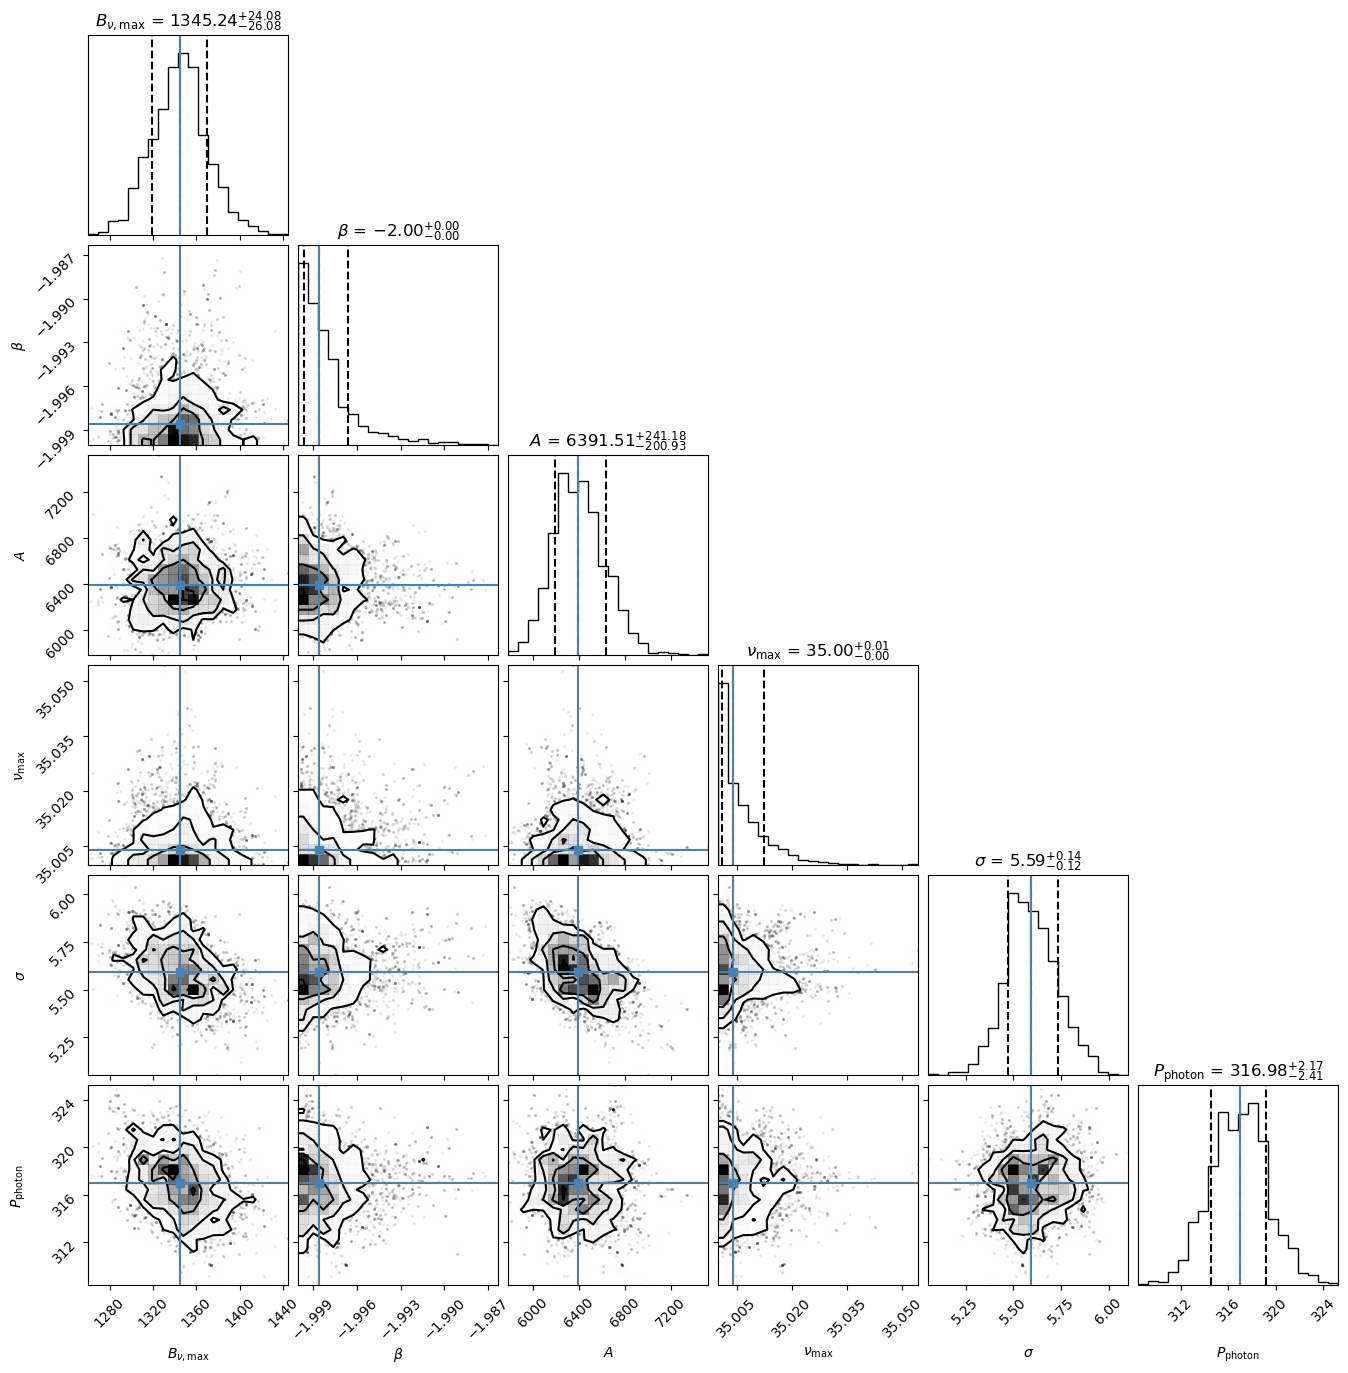

In [12]:
import corner

# Extract the samples from the MCMC sampler
samples = sampler.get_chain(flat=True, discard=800)
best_params = np.median(samples, axis=0)


# Parameter labels for the corner plot
labels = [r"$B_{\nu,\mathrm{max}}$", r"$\beta$", r"$A$", r"$\nu_\mathrm{max}$", r"$\sigma$", r"$P_\mathrm{photon}$"]

# Generate the corner plot
fig = corner.corner(
    samples,
    labels=labels,
    truths=best_params,  # Optional: overlay the initial parameter guesses
    quantiles=[0.16, 0.5, 0.84],  # Show 16th, 50th, and 84th percentiles
    show_titles=True,  # Display the mean ± std in the diagonal plots
    title_fmt=".2f",   # Format for the titles
)

# Show the plot
plt.show()


In [13]:
#get_the_samples
samples = sampler.get_chain(discard=800, flat=True)
# get the best model
best_model = np.median(samples, axis=0)


In [14]:
nu_max=best_model[3]

In [15]:
print('nu_max',nu_max)

nu_max 35.00400154340261


In [16]:
# def power_spectrum_model(nu, B_nu_max, beta, A, nu_max, sigma, P_photon):
all_model = power_spectrum_model(data_df["Frequency (microHz)"],*best_model)
k=noisModel(data_df["Frequency (microHz)"],*best_model)

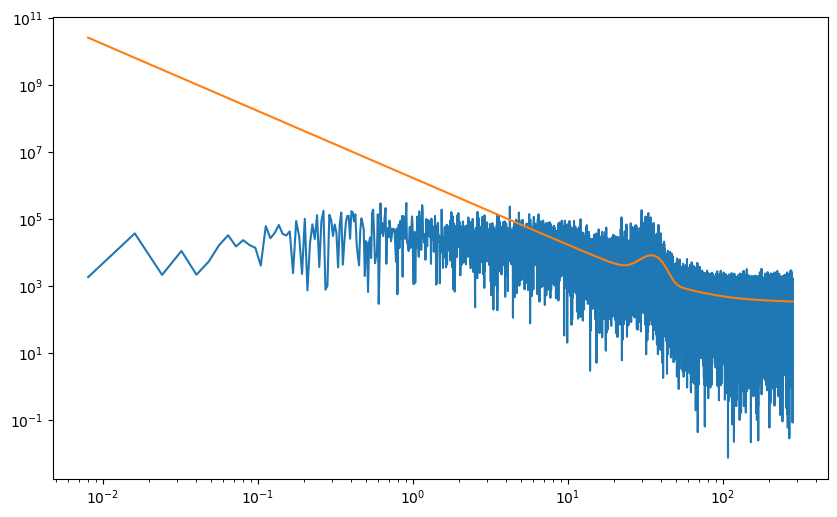

In [17]:
plt.figure(figsize=(10, 6))
plt.loglog(data_df["Frequency (microHz)"], data_df["Power Density (ppm^2/microHz)"], label="Data")
plt.loglog(data_df["Frequency (microHz)"],all_model   , label="Model")
plt.show()

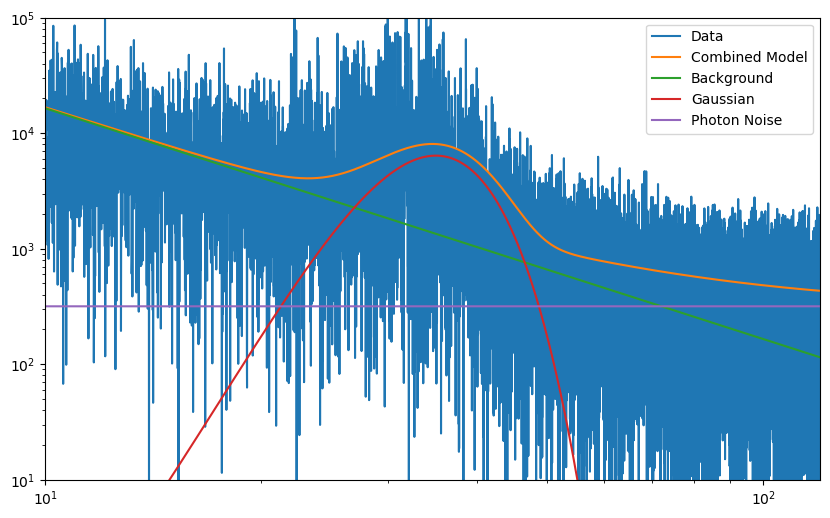

In [18]:
# plot all the components
plt.figure(figsize=(10, 6))
plt.loglog(data_df["Frequency (microHz)"], data_df["Power Density (ppm^2/microHz)"], label="Data")
plt.loglog(data_df["Frequency (microHz)"],all_model, label="Combined Model")
plt.loglog(data_df["Frequency (microHz)"],best_model[0] * (data_df["Frequency (microHz)"] / best_model[3])**best_model[1], label="Background")
plt.loglog(data_df["Frequency (microHz)"],best_model[2] * np.exp(-0.5 * ((data_df["Frequency (microHz)"] - best_model[3]) / best_model[4])**2), label="Gaussian")
# photon noise is constant 
plt.loglog(data_df["Frequency (microHz)"],np.ones(len(data_df["Frequency (microHz)"]))*best_model[5], label="Photon Noise")
plt.ylim(10,1e5)
plt.xlim(10,120)
plt.legend()


In [20]:
orginal_signal=data_df["Power Density (ppm^2/microHz)"] - k
# orginal_signal2 = data_df["Power Density (ppm^2/microHz)"] - all_model

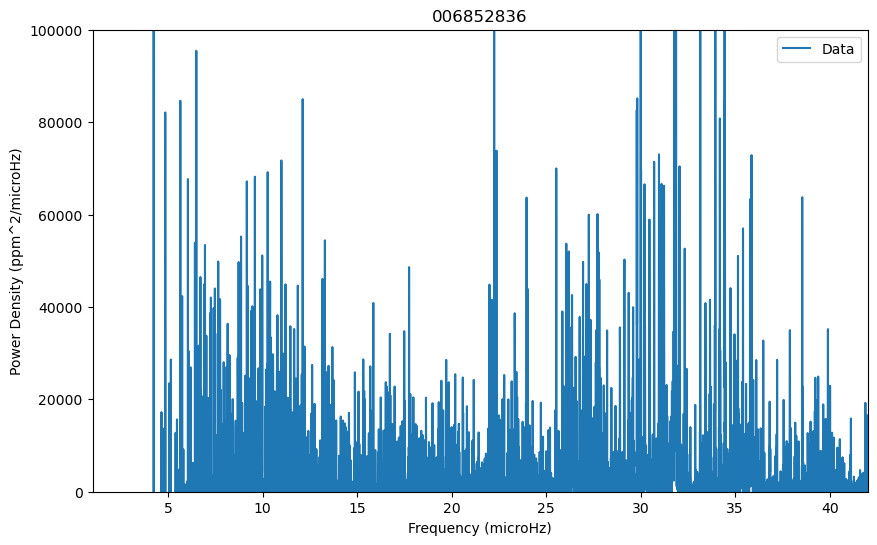

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(data_df["Frequency (microHz)"], orginal_signal, label="Data")
# plt.xlim(28, 42)
# plt.xlabel("Frequency (microHz)")
# plt.ylim(0, 1e5)
# plt.show()
# plt.figure(figsize=(10, 6))
# plt.plot(data_df["Frequency (microHz)"],orginal_signal2   , label="Model")
# plt.loglog(data_df["Frequency (microHz)"],k  , label="Model")
plt.xlim(1, 42)
plt.xlabel("Frequency (microHz)")
plt.ylim(0, 1e5)
plt.ylabel("Power Density (ppm^2/microHz)")
plt.legend()
plt.title(metadata["ID"])
plt.show()


# Lorentzian the second fit.... 


In [23]:
# def lorentzian_model(nu, H, Gamma, delta_nu, alpha, eps, d_0l, n_min, n_max):
#     lorentzian_sum = np.zeros_like(nu)
#     n_max_value = (nu_max / delta_nu) - eps  # Central radial order

#     for n in range(n_min, n_max + 1):  # Sum over radial orders
#         nu_0 = (n + l / 2 + eps + d_0l + alpha * (n - n_max_value) ** 2 / 2) * delta_nu
#         lorentzian_sum += H / (1 + 4 * ((nu - nu_0) / Gamma) ** 2)
    
#     return lorentzian_sum

delta_nu = 4.483
eps = 0.961
alpha = 0.0098

def lorentzian(nu, H, nu_center, Gamma):
    return H / (1 + 4 * ((nu - nu_center) / Gamma)**2)

def lorentzian_model(nu, H1, H2, Gamma1, Gamma2, d_0l):
    n_max_value = (nu_max / delta_nu) - eps  # Central radial order
    nu_center_1 = ((n + 0 / 2 + eps + 0 + alpha / 2 * (n - n_max_value)**2) * delta_nu)
    nu_center_2 = ((n - 1 + 2 / 2 + eps + d_0l + alpha / 2 * (n - 1 - n_max_value)**2) * delta_nu)
    
    return lorentzian(nu, H1, nu_center_1, Gamma1) + lorentzian(nu, H2, nu_center_2, Gamma2)

def log_likelihood_lorentzian(params, nu, power_density):
    H1, H2, Gamma1, Gamma2, d_0l = params
    model = lorentzian_model(nu, H1, H2, Gamma1, Gamma2, d_0l)
    return - np.sum(np.log(model)+ power_density/model)


def log_prior_lorentzian(params):
    H1, H2, Gamma1, Gamma2, d_0l = params
    if 1e4 < H1 < 6e4 and 1e2< H2 < 4e4 and 0.01 < Gamma1 < 1 and 0.01 < Gamma2 < 1 and -1 < d_0l < -0.01:
        return 0.0  # Uniform prior
    return -np.inf


def log_probability_lorentzian(params, nu, power_density):
    lp = log_prior_lorentzian(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_lorentzian(params, nu, power_density)


In [24]:
# Define the range of radial orders (e.g., 8 to 13)
n = 8

# Initial guess
initial_params = [5e4, 2e4, 0.25, 0.25, -0.15]  # Initial guesses for H, Gamma, etc.

# MCMC parameters
ndim = len(initial_params)
nwalkers = 50
nsteps = 2000  # Increase steps for better convergence
pos = initial_params + 1e-4 * np.random.randn(nwalkers, ndim) * initial_params

# Initialize sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_lorentzian, args=(freq[(freq > 39) & (freq < 40.5)], psd[(freq > 39) & (freq < 40.5)]))
sampler.run_mcmc(pos, nsteps, progress=True)

# Analyze results
samples = sampler.get_chain(discard=1700, flat=True)
best_fit_params = np.median(samples, axis=0)
print("Best-fit parameters:", best_fit_params)


100%|██████████| 2000/2000 [01:20<00:00, 24.90it/s]

Best-fit parameters: [ 1.60214041e+04  8.14230170e+03  2.06868042e-02  9.71005352e-01
 -1.37684969e-01]


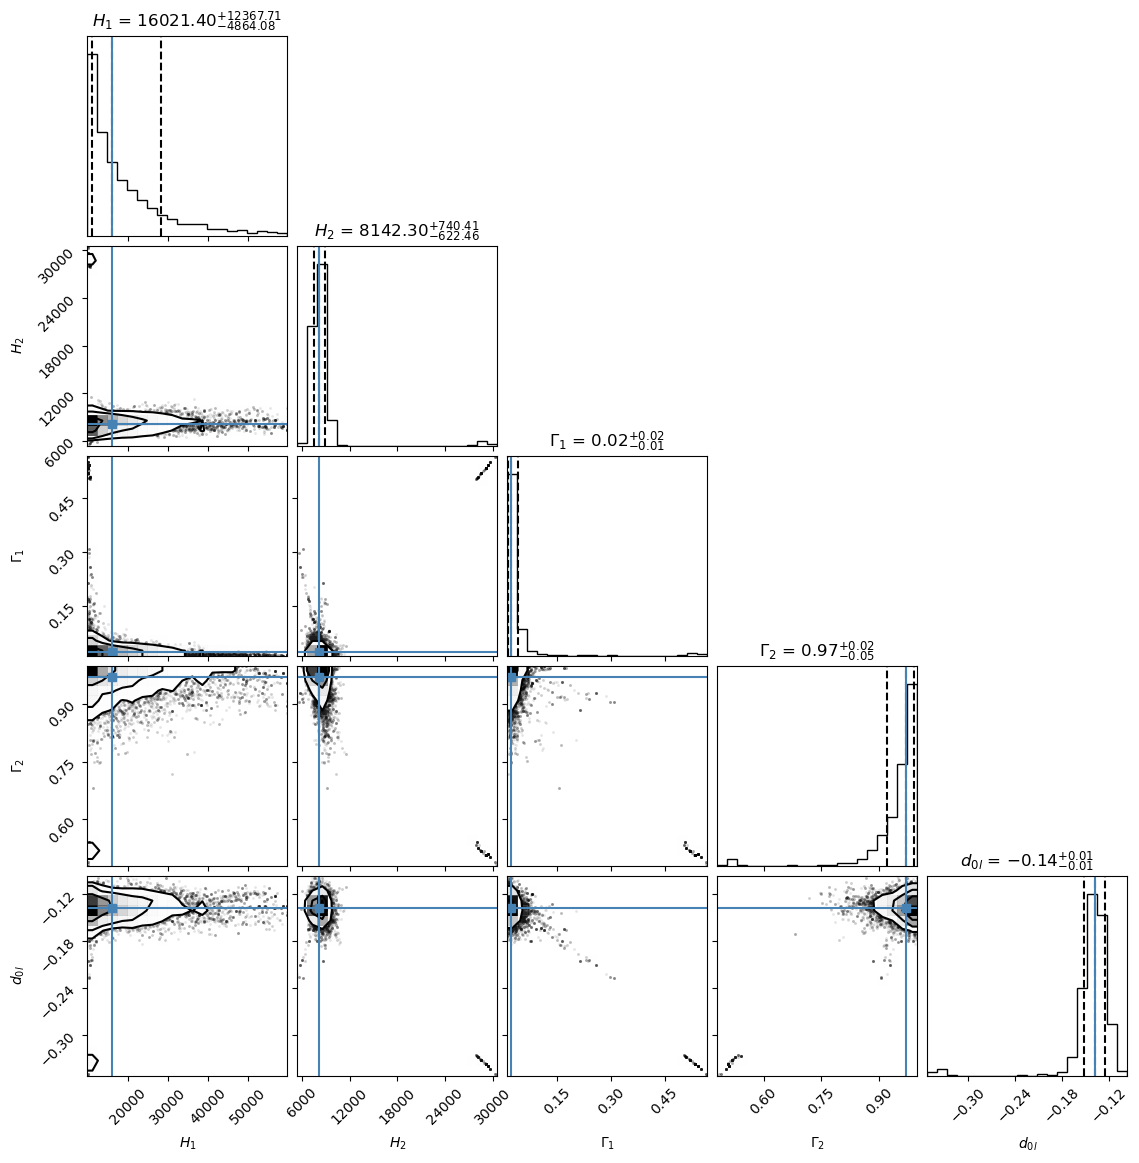

In [25]:
# Generate the corner plot for the Lorentzian model
fig = corner.corner(
    samples,
    labels=[r"$H_1$", r"$H_2$", r"$\Gamma_1$", r"$\Gamma_2$", r"$d_{0l}$"],
    truths=best_fit_params,  # Optional: overlay the initial parameter guesses
    quantiles=[0.16, 0.5, 0.84],  # Show 16th, 50th, and 84th percentiles
    show_titles=True,  # Display the mean ± std in the diagonal plots
    title_fmt=".2f",   # Format for the titles
)

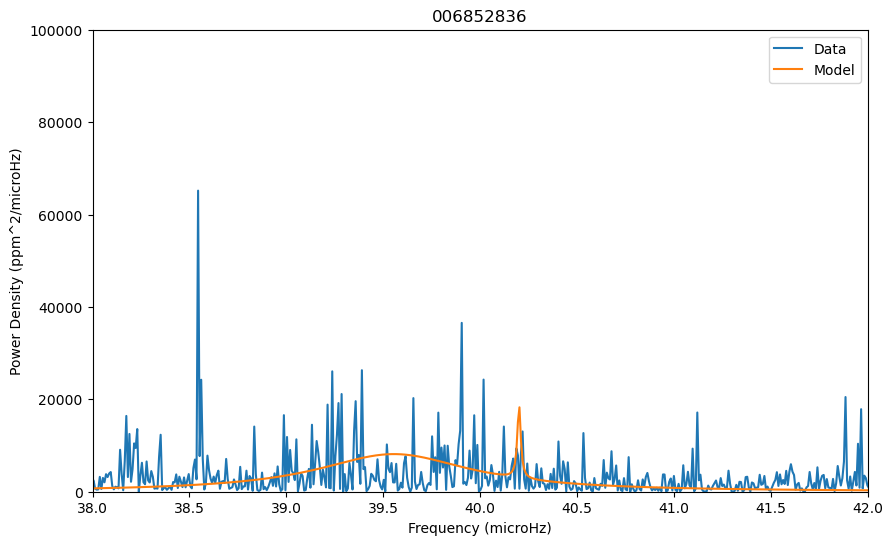

In [26]:
# plot the Lorentzian model for the entire frequency range 28-42 microHz 
plt.figure(figsize=(10, 6))
plt.plot(data_df["Frequency (microHz)"], data_df["Power Density (ppm^2/microHz)"], label="Data")
plt.plot(data_df["Frequency (microHz)"], lorentzian_model(data_df["Frequency (microHz)"], *best_fit_params), label="Model")
plt.xlim(38, 42)
plt.ylim(0, 1e5)
plt.xlabel("Frequency (microHz)")
plt.ylabel("Power Density (ppm^2/microHz)")
plt.legend()
plt.title(metadata["ID"])
plt.show()


In [40]:
alpha = 0.0098

def lorentzian(frequency, H, nu_center, Gamma):
    """Single Lorentzian function."""
    return H / (1 + 4 * ((frequency - nu_center) / Gamma)**2)

def lorentzian_sum(frequency, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu):
    """
    Summation over specific radial orders n=6 and n=7 for l=0 and l=2 modes.
    Each radial order has its own height and linewidth (Gamma).
    """
    n_radial_values = [6, 7]  # Radial orders n=6 and n=7
    n_max = nu_max / Delta_nu - epsilon
    total_model = 0

    for i, n in enumerate(n_radial_values):
        # Frequency centers for l=0 and l=2
        nu_center_l0 = ((n + 1 + epsilon + alpha / 2 * (n + 1 - n_max)**2) * Delta_nu)  # l=0
        nu_center_l2 = ((n + 2 / 2 + epsilon + d02 + alpha / 2 * (n - n_max)**2) * Delta_nu)  # l=2

        # Add Lorentzians with n-dependent heights and Gamma
        total_model += lorentzian(frequency, heights_l0[i], nu_center_l0, gammas_l0[i])  # l=0
        total_model += lorentzian(frequency, heights_l2[i], nu_center_l2, gammas_l2[i])  # l=2

    return total_model

def log_likelihood(theta, frequency, power_density):
    epsilon, d02, Delta_nu = theta[:3]
    heights_l0 = theta[3:5]
    heights_l2 = theta[5:7]
    gammas_l0 = theta[7:9]
    gammas_l2 = theta[9:11]

    model = lorentzian_sum(frequency, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu)
    return -np.sum(np.log(model) + power_density / model)

def log_prior(theta):
    epsilon, d02, Delta_nu = theta[:3]
    heights_l0 = theta[3:5]
    heights_l2 = theta[5:7]
    gammas_l0 = theta[7:9]
    gammas_l2 = theta[9:11]

    # Core parameter priors
    if not (0.01 < epsilon < 1.0 and -1.0 < d02 < 0.0 and 3 < Delta_nu < 6):
        return -np.inf

    # Heights priors
    if not (np.all(2e4 < heights_l0) and np.all(heights_l0 < 5e4) and
            np.all(1e4 < heights_l2) and np.all(heights_l2 < 3e4)):
        return -np.inf

    # Gamma priors
    if not (np.all(0.01 < gammas_l0) and np.all(gammas_l0 < 1) and
            np.all(0.01 < gammas_l2) and np.all(gammas_l2 < 1)):
        return -np.inf

    return 0.0

def log_probability(theta, frequency, power_density):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, power_density)

# Data subset for peak region
frequency_peak = freq[((freq > 32.5) & (freq < 36)) | ((freq > 39) & (freq < 41))]
power_density_peak = psd[((freq > 32.5) & (freq < 36)) | ((freq > 39) & (freq < 41))]

# Initial guesses
initial_guess = [
    0.9, -0.1, 4.5,  # epsilon, d02, Delta_nu
    4e4, 4e4,  # Heights l=0
    2e4, 2e4,  # Heights l=2
    0.25, 0.25,  # Gammas l=0
    0.25, 0.25   # Gammas l=2
]

# MCMC setup
ndim = len(initial_guess)
nwalkers = 50
pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim) * initial_guess

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(frequency_peak, power_density_peak))
sampler.run_mcmc(pos, 10000, progress=True)

# Analyze results
samples = sampler.get_chain(discard=5000, flat=True)
best_params = np.median(samples, axis=0)
print("Best-fit parameters:", best_params)


100%|██████████| 10000/10000 [11:46<00:00, 14.16it/s]


Best-fit parameters: [ 9.76328739e-01 -6.32808883e-02  4.28906186e+00  2.12467580e+04
  3.60963149e+04  1.37276615e+04  2.79423734e+04  9.77525415e-01
  9.61063554e-01  8.09445581e-01  5.10078304e-01]


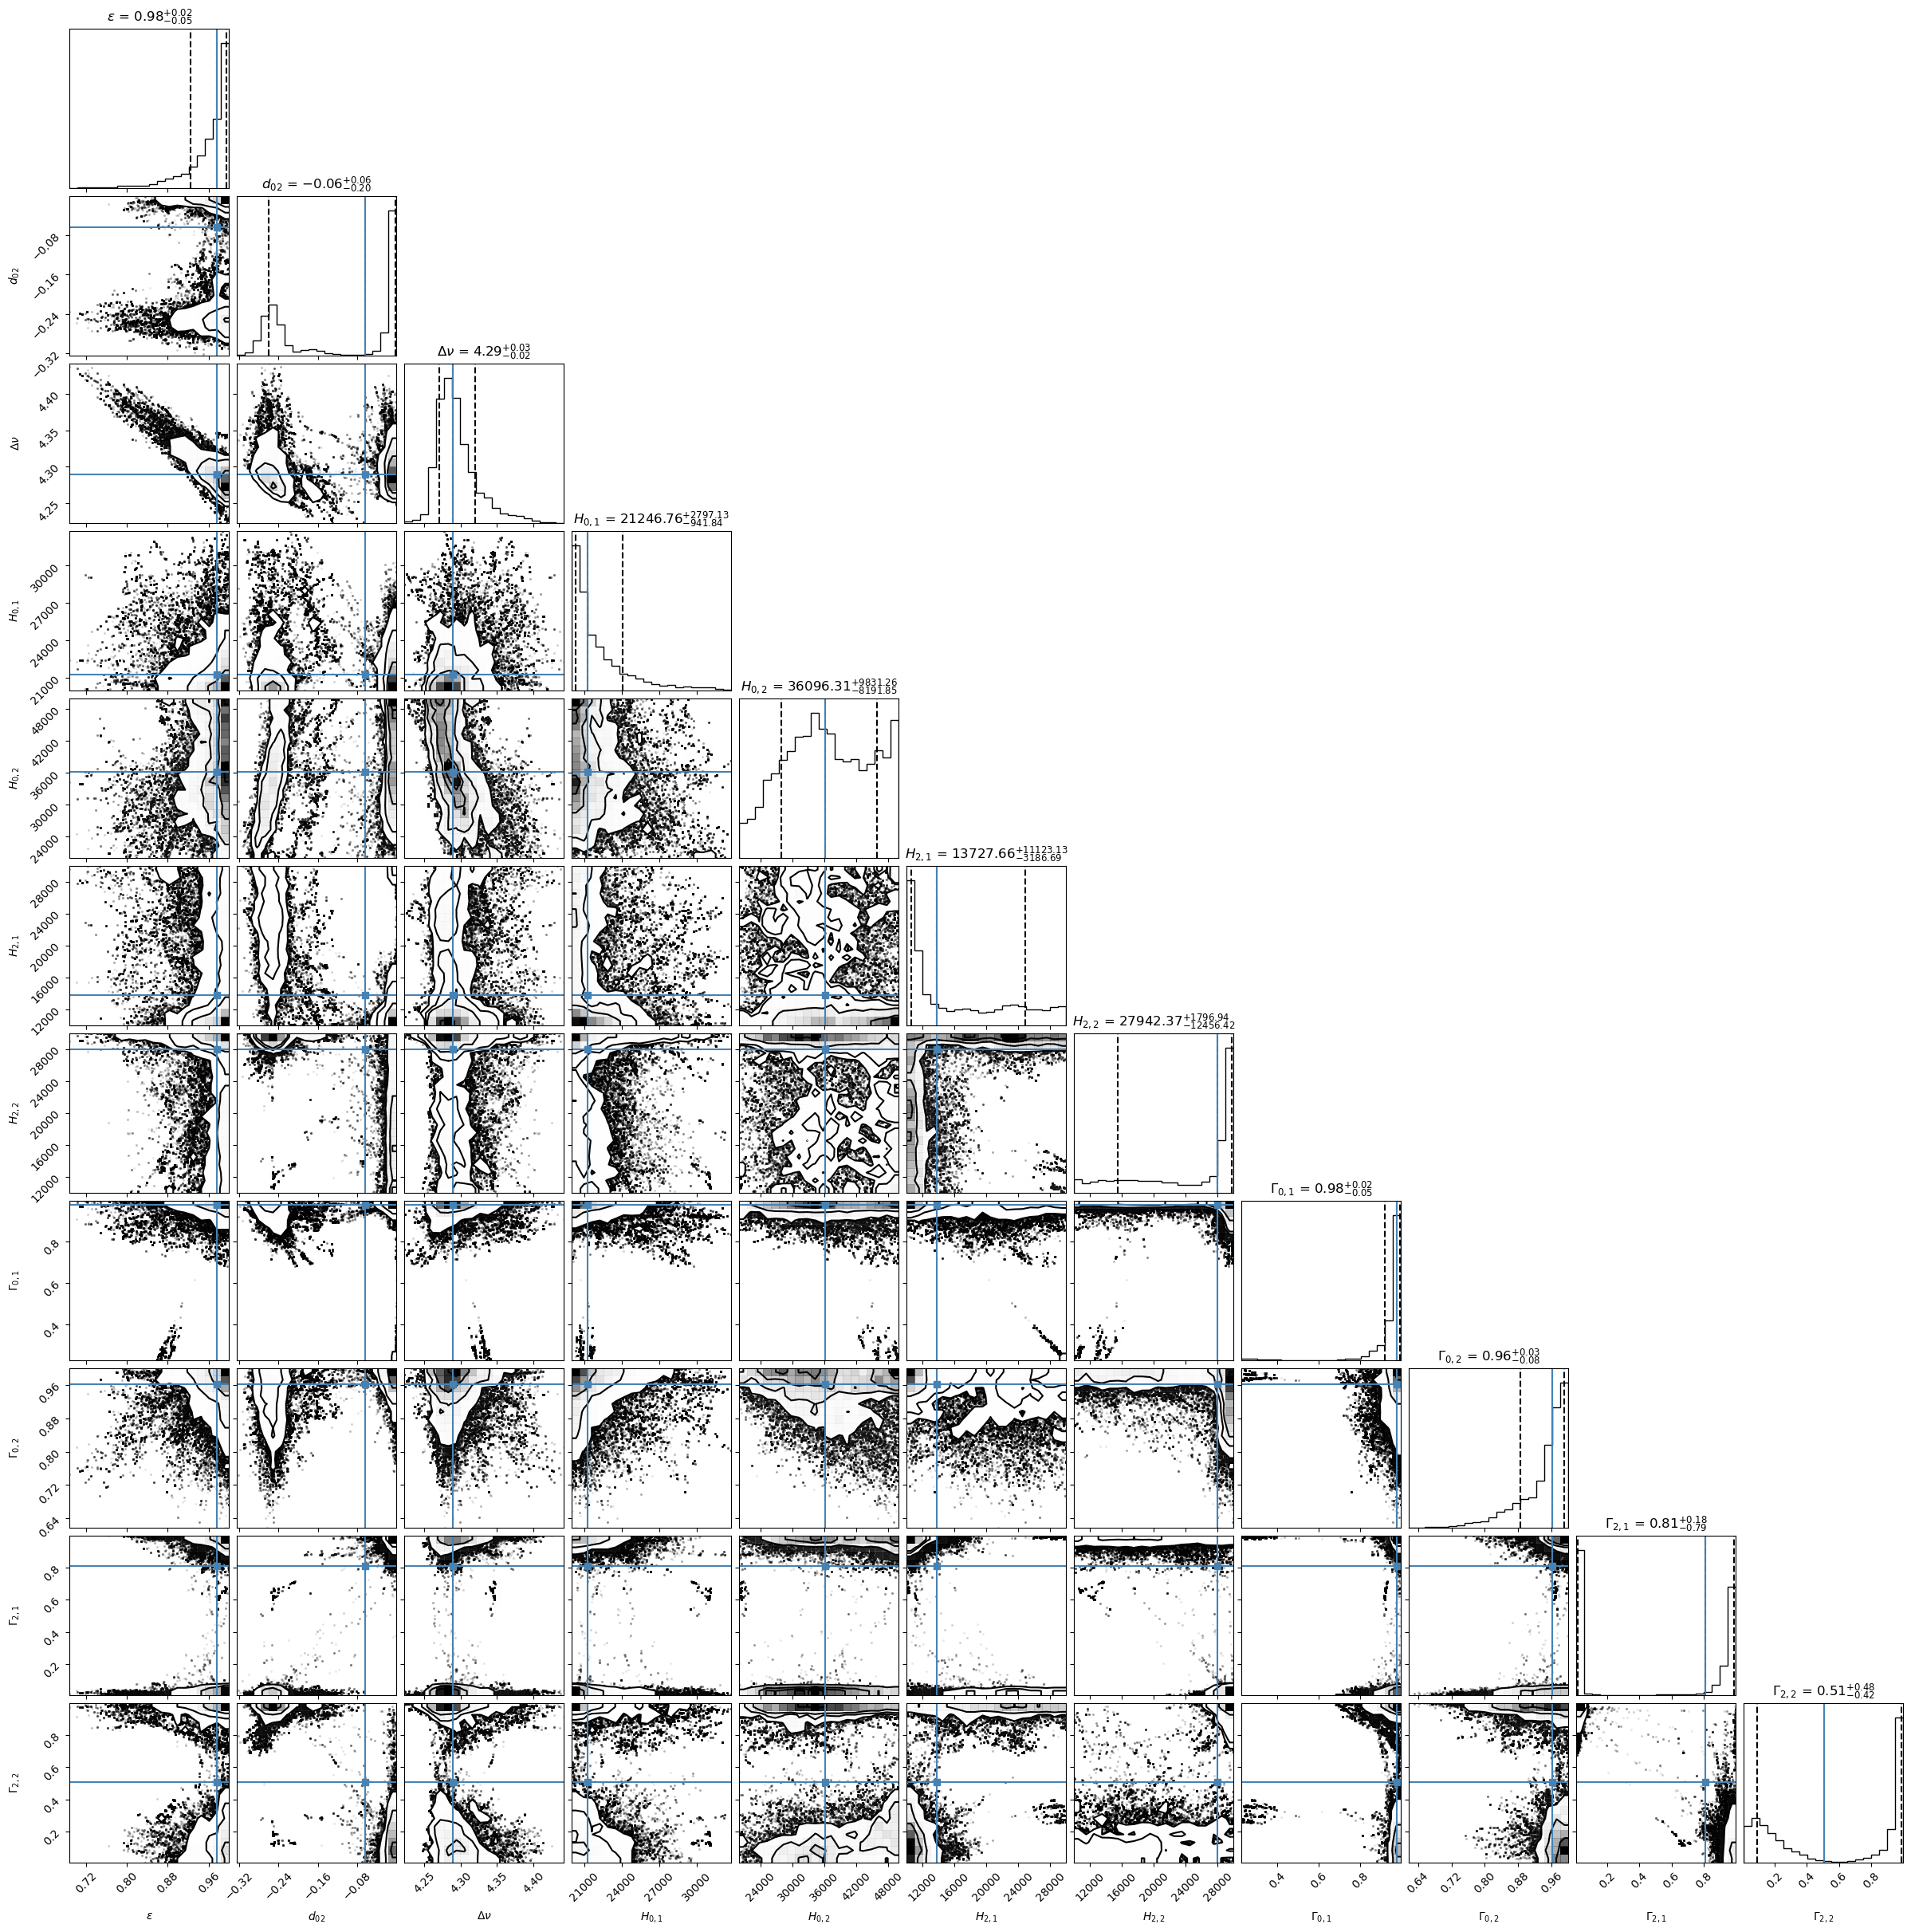

In [41]:
# Generate the corner plot for the Lorentzian model
fig = corner.corner(
    samples,
    labels=[
        r"$\epsilon$", r"$d_{02}$", r"$\Delta\nu$",
        r"$H_{0,1}$", r"$H_{0,2}$", r"$H_{2,1}$", r"$H_{2,2}$",
        r"$\Gamma_{0,1}$", r"$\Gamma_{0,2}$", r"$\Gamma_{2,1}$", r"$\Gamma_{2,2}$"
    ],
    truths=best_params,  # Optional: overlay the initial parameter guesses
    quantiles=[0.16, 0.5, 0.84],  # Show 16th, 50th, and 84th percentiles
    show_titles=True,  # Display the mean ± std in the diagonal plots
    title_fmt=".2f",   # Format for the titles
)

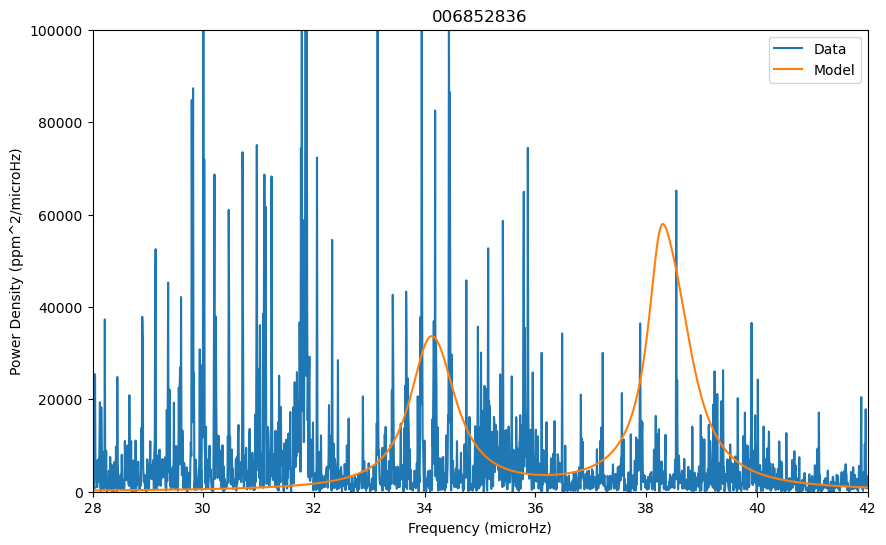

In [42]:
# Extract parameters from the best-fit parameters
epsilon, d02, Delta_nu = best_params[:3]
heights_l0 = best_params[3:5]
heights_l2 = best_params[5:7]
gammas_l0 = best_params[7:9]
gammas_l2 = best_params[9:11]

# Plot the Lorentzian model for the entire frequency range 28-42 microHz
plt.figure(figsize=(10, 6))
plt.plot(freq, psd, label="Data")
plt.plot(
    freq,
    lorentzian_sum(freq, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu),
    label="Model"
)
plt.xlim(28, 42)
plt.ylim(0, 1e5)
plt.xlabel("Frequency (microHz)")
plt.ylabel("Power Density (ppm^2/microHz)")
plt.legend()
plt.title(metadata["ID"])
plt.show()


In [ ]:
# value of delta nu 
print('Delta_nu',Delta_nu)


Delta_nu 4.5697180629283345


In [43]:
nu_max = 38.1443

# now we can use the delta nu to fit alpha as well and fit  three pick in the data
def lorentzian(frequency, H, nu_center, Gamma):
    """Single Lorentzian function."""
    return H / (1 + 4 * ((frequency - nu_center) / Gamma)**2)

def lorentzian_sum(frequency, heights_l0, heights_l1, heights_l2, gammas_l0, gammas_l1, gammas_l2, epsilon, d02, Delta_nu, alpha):
    """
    Summation over specific radial orders n=6, n=7, and n=8 for l=0, l=1, and l=2 modes.
    Each radial order has its own height and linewidth (Gamma).
    """
    n_radial_values = [6, 7, 8]  # Radial orders n=6, n=7, and n=8
    n_max = nu_max / Delta_nu - epsilon
    total_model = 0

    for i, n in enumerate(n_radial_values):
        # Frequency centers for l=0, l=1, and l=2
        nu_center_l0 = ((n + epsilon + alpha / 2 * (n - n_max)**2) * Delta_nu)  # l=0
        # nu_center_l1 = ((n + 1 / 2 + epsilon + d02 + alpha / 2 * (n - n_max)**2) * Delta_nu)  # l=1
        nu_center_l2 = ((n - 1 + 2 / 2 + epsilon + d02 + alpha / 2 * (n - 1 - n_max)**2) * Delta_nu)  # l=2

        # Add Lorentzians with n-dependent heights and Gamma
        total_model += lorentzian(frequency, heights_l0[i], nu_center_l0, gammas_l0[i])  # l=0
        # total_model += lorentzian(frequency, heights_l1[i], nu_center_l1, gammas_l1[i])  # l=1
        total_model += lorentzian(frequency, heights_l2[i], nu_center_l2, gammas_l2[i])  # l=2

    return total_model

def log_likelihood(theta, frequency, power_density):
    epsilon, d02, Delta_nu = theta[:3]
    heights_l0 = theta[3:6]
    heights_l1 = theta[6:9]
    heights_l2 = theta[9:12]
    gammas_l0 = theta[12:15]
    gammas_l1 = theta[15:18]
    gammas_l2 = theta[18:21]
    alpha = theta[21]

    model = lorentzian_sum(frequency, heights_l0, heights_l1, heights_l2, gammas_l0, gammas_l1, gammas_l2, epsilon, d02, Delta_nu, alpha)
    return -np.sum(np.log(model) + power_density / model)

def log_prior(theta):
    epsilon, d02, Delta_nu = theta[:3]
    heights_l0 = theta[3:6]
    heights_l1 = theta[6:9]
    heights_l2 = theta[9:12]
    gammas_l0 = theta[12:15]
    gammas_l1 = theta[15:18]
    gammas_l2 = theta[18:21]
    alpha = theta[21]

    # Core parameter priors
    if not (0.01 < epsilon < 1.0 and -1.0 < d02 < 0.0 and 3 < Delta_nu < 6 and 0.005 < alpha < 0.5):
        return -np.inf

    # Heights priors
    if not (np.all(2e4 < heights_l0) and np.all(heights_l0 < 5e4) and
            np.all(1e4 < heights_l1) and np.all(heights_l1 < 3e4) and
            np.all(1e4 < heights_l2) and np.all(heights_l2 < 3e4)):
        return -np.inf

    # Gamma priors
    if not (np.all(0.01 < gammas_l0) and np.all(gammas_l0 < 0.5) and
            np.all(0.01 < gammas_l1) and np.all(gammas_l1 < 1) and
            np.all(0.01 < gammas_l2) and np.all(gammas_l2 < 1 )):
        return -np.inf

    return 0.0

def log_probability(theta, frequency, power_density):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, power_density)

# Data subset for peak region
frequency_peak = freq[((freq > 31.55) & (freq < 32.5)) | ((freq > 34.5) & (freq < 36)) | ((freq > 39) & (freq < 41))]
power_density_peak = psd[((freq > 31.55) & (freq < 32.5)) | ((freq > 34.5) & (freq < 36)) | ((freq > 39) & (freq < 41))]
# Initial guesses
initial_guess = [
    0.9, -0.1, 4.5,  # epsilon, d02, Delta_nu
    4e4, 4e4, 4e4,  # Heights l=0
    2e4, 2e4, 2e4,  # Heights l=1
    2e4, 2e4, 2e4,  # Heights l=2
    0.25, 0.25, 0.25,  # Gammas l=0
    0.25, 0.25, 0.25,  # Gammas l=1
    0.25, 0.25, 0.25,   # Gammas l=2
    0.01
]

# MCMC setup
ndim = len(initial_guess)
nwalkers = 25*2
pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim) * initial_guess

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(frequency_peak, power_density_peak))
sampler.run_mcmc(pos, 10000, progress=True)



100%|██████████| 10000/10000 [20:07<00:00,  8.28it/s]


State([[ 0.94929681 -0.03102221  4.46858264 ...  0.08546071  0.54710119
   0.02314264]
 [ 0.99237936 -0.01351119  4.4439017  ...  0.12918846  0.7129367
   0.02883506]
 [ 0.99892562 -0.0485296   4.44446114 ...  0.36557209  0.67857721
   0.02057767]
 ...
 [ 0.9795742  -0.04223508  4.44852653 ...  0.39019826  0.57747011
   0.01871518]
 [ 0.96575364 -0.00871504  4.44562399 ...  0.40819175  0.61119061
   0.0152045 ]
 [ 0.98981335 -0.01453378  4.44365663 ...  0.01355967  0.76152632
   0.04064085]], log_prob=[-5483.60690389 -5487.87730308 -5476.9287973  -5476.1715225
 -5474.41985968 -5505.0072003  -5476.93110701 -5471.33526746
 -5486.17010102 -5471.04181795 -5486.58049799 -5501.40588626
 -5481.21993095 -5472.54922119 -5480.79669631 -5484.43269585
 -5482.45941976 -5480.90601016 -5477.55505537 -5475.11869526
 -5477.67885404 -5488.46990847 -5481.49028876 -5476.63524318
 -5467.71251244 -5468.0503204  -5485.4239826  -5482.25608931
 -5483.44409528 -5481.769667   -5478.71597123 -5485.55412646
 -5481

In [44]:
# Analyze results
samples = sampler.get_chain(discard=8000, flat=True)
best_params = np.median(samples, axis=0)
print("Best-fit parameters:", best_params)



Best-fit parameters: [ 9.92182221e-01 -3.18009747e-02  4.45018838e+00  4.60357737e+04
  3.88006407e+04  2.58405339e+04  2.71635519e+04  1.89230093e+04
  1.13655675e+04  1.99157738e+04  1.18888327e+04  1.57635556e+04
  4.04276921e-01  4.86713185e-01  2.04739146e-02  9.54413426e-01
  7.50559551e-01  4.45925048e-02  7.30586403e-01  2.37553179e-01
  6.07703648e-01  2.33376146e-02]


In [ ]:
fig = corner.corner(
    samples,
    labels=[
        r"$\epsilon$", r"$d_{02}$", r"$\Delta\nu$",
        r"$H_{0,1}$", r"$H_{0,2}$", r"$H_{0,3}$",
        r"$H_{1,1}$", r"$H_{1,2}$", r"$H_{1,3}$",
        r"$H_{2,1}$", r"$H_{2,2}$", r"$H_{2,3}$",
        r"$\Gamma_{0,1}$", r"$\Gamma_{0,2}$", r"$\Gamma_{0,3}$",
        r"$\Gamma_{1,1}$", r"$\Gamma_{1,2}$", r"$\Gamma_{1,3}$",
        r"$\Gamma_{2,1}$", r"$\Gamma_{2,2}$", r"$\Gamma_{2,3}$",
        r"$\alpha$"
    ],
    truths=best_params,  # Optional: overlay the initial parameter guesses
    quantiles=[0.16, 0.5, 0.84],  # Show 16th, 50th, and 84th percentiles
    show_titles=True,  # Display the mean ± std in the diagonal plots
    title_fmt=".2f",   # Format for the titles
)


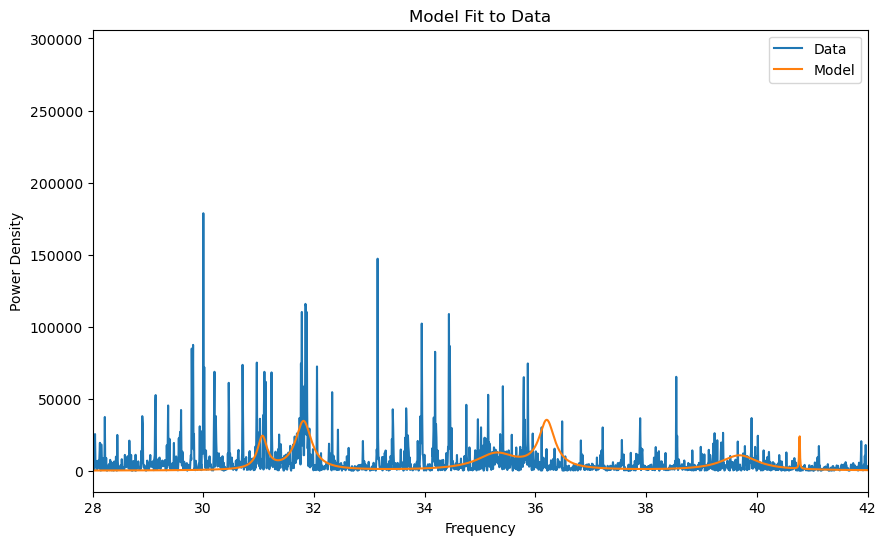

In [ ]:
# Unpack the parameters from best_params
epsilon, d02, Delta_nu = best_params[:3]
heights_l0 = best_params[3:6]
heights_l1 = best_params[6:9]
heights_l2 = best_params[9:12]
gammas_l0 = best_params[12:15]
gammas_l1 = best_params[15:18]
gammas_l2 = best_params[18:21]
alpha = best_params[21]

# Plot the data and the model
plt.figure(figsize=(10, 6))
plt.plot(freq, psd, label="Data")
plt.plot(
    freq,
    lorentzian_sum(freq, heights_l0, heights_l1, heights_l2, gammas_l0, gammas_l1, gammas_l2, epsilon, d02, Delta_nu, alpha),
    label="Model"
)
plt.xlim(28, 42)
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.title("Model Fit to Data")
plt.show()


In [34]:
# print the value of alpha
print('alpha',alpha)


alpha 0.0073202296141455375


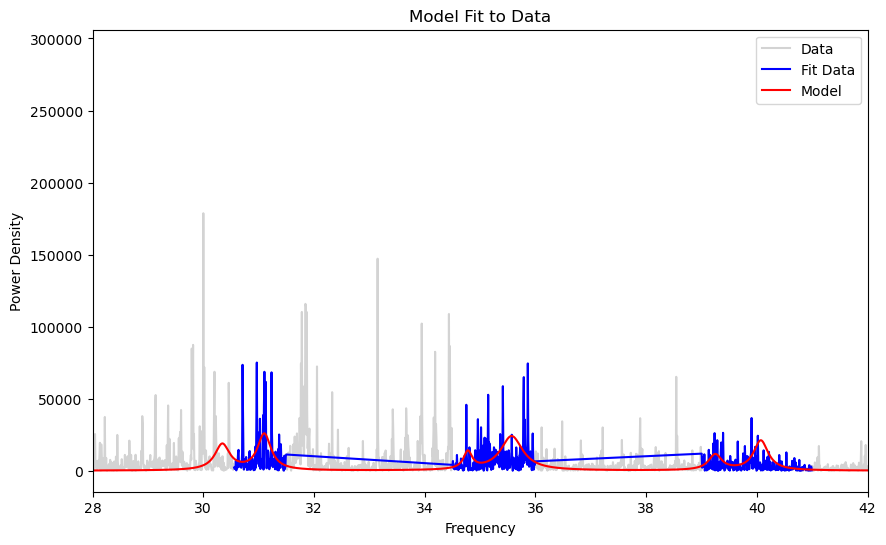

In [ ]:
# Unpack the parameters from best_params
epsilon, d02, Delta_nu = best_params[:3]
heights_l0 = best_params[3:6]
heights_l1 = best_params[6:9]
heights_l2 = best_params[9:12]
gammas_l0 = best_params[12:15]
gammas_l1 = best_params[15:18]
gammas_l2 = best_params[18:21]
alpha = best_params[21]

# Plot the data and the model
plt.figure(figsize=(10, 6))
# Plot the entire data in light gray
plt.plot(freq, psd, color='lightgray', label="Data")

# Highlight the fit part in bright blue
fit_mask = (freq > 29.6) & (freq < 31.5) | (freq > 34.5) & (freq < 36) | (freq > 39) & (freq < 41)
plt.plot(freq[fit_mask], psd[fit_mask], color='blue', label="Fit Data")

# Plot the model
plt.plot(
    freq,
    lorentzian_sum(freq, heights_l0, heights_l1, heights_l2, gammas_l0, gammas_l1, gammas_l2, epsilon, d02, Delta_nu, alpha),
    color='red', label="Model"
)

plt.xlim(28, 42)
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.title("Model Fit to Data")
plt.show()
